# PyTorch for NLP

## Was ist PyTorch?

**PyTorch** ist eine leistungsstarke und flexible Open-Source-Bibliothek für maschinelles Lernen, die vor allem für die Entwicklung und das Training von **Neuralen Netzen** entwickelt wurde. Sie wurde von **Facebook's AI Research lab (FAIR)** entwickelt und hat sich schnell als eine der beliebtesten Bibliotheken für Deep Learning etabliert.

Mit PyTorch ist es einfach verschiedene Modell Architekturen aufzubauen. Ebenso bietet es verschiedene Möglichkeiten Daten auf einfache weise einzulesen und zu verarbeiten. Damit ist es gut geeignet für moderne Deep Learning Anwendungen.

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Praktisches Beispiel

In diesem praktischen Beispiel werde ich PyTorch anhand einer **Sentimentanalyse** auf Tweets vorstellen. Ich habe ein Modell entwickelt, das erkennt, ob ein Tweet **positiv** oder **negativ** ist. Dabei werde ich die gesamte **Pipeline** durchgehen – vom **Einlesen der Daten**, über das **Erstellen und Trainieren des Modells** bis hin zum **Evaluieren** der Ergebnisse. 

## Trainingsparameter

Zunächst definiere ich einige Parameter welche später für das Training gebraucht werden. Ebenfalls wird ein **Seed** gesetzt, um die Ergebnisse reproduzierbar zu machen.

In [15]:
import torch

TRAINING_SIZE = 10000
TRAIN_PERCENT = 0.8
VAL_PERCENT = 0.1
TEST_PERCENT = 1.0 - TRAIN_PERCENT - VAL_PERCENT
BATCH_SIZE = 64
MAX_LEN = 128
EMBED_DIM = 128
LEARNING_RATE = 1e-3
EPOCHS = 50
PATIENCE = 3
RUN_NAME = "run1"
OUTPUT = "./pytorch_output"
TRAIN_MODEL = False
SEED = 0

torch.manual_seed(SEED)

## Datenbeschaffung

Als Datensatz nehme ich wie in den Assignments den NLTK Twitter Datensatz. Diese lese ich zunächst ein und generiere Labels für sie, basierend darauf ob sie positiv oder negativ sind.

In [16]:
from nltk.corpus import twitter_samples

In [17]:
assert TRAINING_SIZE <= 10000
postive_tweets = twitter_samples.strings("positive_tweets.json")[
    : int(TRAINING_SIZE / 2)
]
negative_tweets = twitter_samples.strings("negative_tweets.json")[
    : int(TRAINING_SIZE / 2)
]

print("Number of positive tweets: ", len(postive_tweets))
print("Number of negative tweets: ", len(negative_tweets))
print("Total number of tweets: ", len(postive_tweets) + len(negative_tweets))

Number of positive tweets:  5000
Number of negative tweets:  5000
Total number of tweets:  10000


In [18]:
tweets = postive_tweets + negative_tweets
labels = [1] * len(postive_tweets) + [0] * len(negative_tweets)

## PyTorch Dataset

Als ersten zentralen Punkt von PyTorch zeige ich ein **PyTorch Dataset**. Diese werden verwendet, um Daten effizient einzulesen und zu verarbeiten. Ein Dataset in PyTorch ermöglicht es, Daten flexibel zu handhaben und in Batches zu laden, was beim Training von Deep Learning-Modellen sehr wichtig ist.

Ein **Dataset** ist in PyTorch eine abstrakte Klasse, die eine Schnittstelle für das Laden von Daten darstellt. Du kannst deine eigenen Datasets erstellen, indem du die Klasse `torch.utils.data.Dataset` erweiterst.

#### Grundlegende Struktur eines PyTorch Datasets

Damit eine Klasse eine Subklasse eines PyTorch **`Dataset`** sein kann, muss sie zwei wesentliche Methoden implementieren:

1. **`__len__`**: Gibt die Anzahl der Samples im Dataset zurück.
2. **`__getitem__`**: Gibt ein Sample des Datasets zurück, das als `input` und `label` für das Modell verwendet werden kann.


In [19]:
from htwgnlp.preprocessing import TweetProcessor
from pytorch_nlp.dataset import SentimentDataset

tweet_processor = TweetProcessor()

dataset = SentimentDataset(
    tweets=tweets,
    labels=labels,
    processor=tweet_processor.process_tweet,
    max_length=MAX_LEN,
)

dataset[100]

(tensor([381, 382, 383,  74,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0]),
 tensor(1))

Der Datensatz wird anschließend in Trainings-, Validierungs- und Testdatensatz aufgeteilt.

In [20]:
assert TRAIN_PERCENT + VAL_PERCENT + TEST_PERCENT == 1

train_size = int(TRAIN_PERCENT * len(dataset))
val_size = int(VAL_PERCENT * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

print(
    f"Train Size: {len(train_dataset)}, Validation Size: {len(val_dataset)}, Test Size: {len(test_dataset)}"
)

Train Size: 8000, Validation Size: 1000, Test Size: 1000


## PyTorch DataLoader

Der **`DataLoader`** in PyTorch ist eine Klasse, die das Laden von Daten aus einem Dataset erleichtert. Er übernimmt das Aufteilen der Daten in **Batches**, das **Shuffeln** der Daten und bietet die Möglichkeit, die Daten auf mehrere **Prozesse** zu verteilen, um die Datenvorbereitung während des Trainings zu beschleunigen. Der `DataLoader` wird häufig zusammen mit der `Dataset`-Klasse verwendet, die die Datenstruktur und das Abrufen einzelner Samples definiert.

### Hauptfunktionen des `DataLoader`:

- **Batches**: Teilt die Daten in Batches auf, die für das Training verwendet werden.
- **Shuffling**: Mischen der Daten, um die Reihenfolge der Trainingsbeispiele zufällig zu machen, was das Modell robuster gegen Überanpassung macht.
- **Parallelisierung**: Ermöglicht das Laden von Daten mit mehreren Prozessen, was die Ladegeschwindigkeit bei großen Datensätzen verbessert.

In [21]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## PyTorch Model

In PyTorch bezeichnet das **Model** die Architektur eines neuronalen Netzwerks, die als Subklasse der `torch.nn.Module`-Klasse erstellt wird. Ein Modell in PyTorch besteht aus verschiedenen **Schichten** (z. B. `Linear`, `Conv2d`, `RNN`), die in der `__init__`-Methode definiert werden, und einer **Vorwärtsmethode (`forward`)**, die die Eingabedaten durch das Netzwerk leitet.

Das Modell wird verwendet, um Eingabedaten zu transformieren und Vorhersagen zu treffen. Es wird mit den **Trainingsdaten** trainiert und mit den **Validierungsdaten** validiert. Durch den Aufruf von `model.train()` wird das Modell in den Trainingsmodus versetzt, während es mit `model.eval()` in den Evaluierungsmodus wechselt, um Verhalten wie Dropout zu deaktivieren.

Das Modell enthält auch die **Gewichte** (Parameter), die während des Trainings aktualisiert werden, und diese werden mithilfe von Optimierern wie **Adam** oder **SGD** optimiert.

In [22]:
from pytorch_nlp.model import SentimentModel

model = SentimentModel(vocab_size=len(dataset.vocab), embedding_dim=EMBED_DIM)

print(model)

SentimentModel(
  (embedding): Embedding(10507, 128, padding_idx=0)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


## GPU-Unterstützung

Pytorch bietet einfache Möglichkeiten, um Berechnungen auf einer **GPU** durchzuführen. Dies kann die Trainingsgeschwindigkeit erheblich verbessern.

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SentimentModel(
  (embedding): Embedding(10507, 128, padding_idx=0)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

## Trainings Loop

Der Trainingsloop ist der Kern des Trainingsprozesses. Dabei werden die Trainingsdaten in Batches geladen, durch das Modell geleitet, die Vorhersagen mit den Labels verglichen und der Fehler berechnet. Anschließend wird der Fehler zurückpropagiert, um die Gewichte des Modells zu aktualisieren. Dieser Prozess wird über mehrere **Epochen** wiederholt, bis das Modell konvergiert.

In [24]:
import torch.nn as nn
import torch.optim as optim
from pytorch_nlp.train import train_model, load_metrics

criterion = nn.BCELoss()  # Binary cross-entropy loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

if TRAIN_MODEL:
    train_losses, val_losses, val_accuracies = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        num_epochs=EPOCHS,
        early_stopping=True,
        patience=5,
        output=OUTPUT,
        run_name=RUN_NAME,
    )
else:
    epochs, train_losses, val_losses, val_accuracies = load_metrics(
        f"./{OUTPUT}/{RUN_NAME}.csv"
    )

Metrics loaded from ././pytorch_output/run1.csv


Speichert man sich die Historie des Trainingsverlaufs (Loss, Accuracy etc.) kann man später den Verlauf des Trainings analysieren und visualisieren.

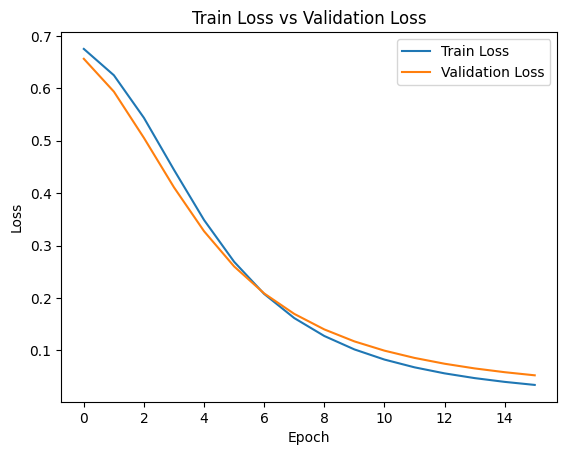

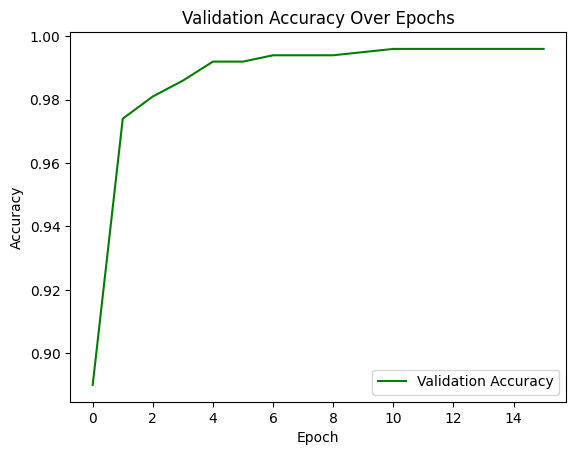

In [25]:
# Visualize the training history (example with matplotlib)
import matplotlib.pyplot as plt

# Plot training loss and validation loss
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Train Loss vs Validation Loss")
plt.show()

# Plot validation accuracy
plt.plot(val_accuracies, label="Validation Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy Over Epochs")
plt.show()

## Evaluierung

Nach dem Training wird das Modell mit den **Testdaten** evaluiert, um die **Genauigkeit** und **Leistung** des Modells zu bewerten. Die Genauigkeit wird als **Accuracy** berechnet, die die Anzahl der korrekten Vorhersagen durch die Gesamtanzahl der Vorhersagen teilt.

In [26]:
from pytorch_nlp.evaluate import evaluate_model

if not TRAIN_MODEL:
    print("Loading model from disk...")
    model.load_state_dict(torch.load(f"./{OUTPUT}/{RUN_NAME}.pt", weights_only=True))

accuracy, avg_loss = evaluate_model(
    model=model,
    test_loader=test_loader,
    criterion=criterion,
    device=device,
)

Loading model from disk...
Test Accuracy: 0.9910
Test Loss: 0.1002
Correctly classified samples: 991
Wrongly classified samples: 9
